In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import MinMaxScaler

### 获取数据

In [76]:
new_data = pd.read_csv('new_data.csv')

In [77]:
new_data = new_data.drop(['Unnamed: 0', 'light', 'wind_speed', 'wind_direction_angle', 'weather_status', 'precipitation'], axis=1)

In [78]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float64
 1   temperature  75552 non-null  float64
 2   humidity     75552 non-null  float64
 3   pressure     75552 non-null  float64
 4   visibility   75552 non-null  float64
 5   holiday      75552 non-null  float64
 6   minute       75552 non-null  float64
 7   week         75552 non-null  float64
 8   year         75552 non-null  float64
dtypes: float64(9)
memory usage: 5.2 MB


In [79]:
new_data = new_data.astype(np.float32)

In [80]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75552 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        75552 non-null  float32
 1   temperature  75552 non-null  float32
 2   humidity     75552 non-null  float32
 3   pressure     75552 non-null  float32
 4   visibility   75552 non-null  float32
 5   holiday      75552 non-null  float32
 6   minute       75552 non-null  float32
 7   week         75552 non-null  float32
 8   year         75552 non-null  float32
dtypes: float32(9)
memory usage: 2.6 MB


2021年、2022年、2023年年初电力负荷均出现了明显的先下降后上升过程，但原因不明，需要和电力公司沟通，了解原因。因此在模型训练和测试时选择将这段时间的数据忽略。

删去2021-1-21到2021-2-6，2022-2-9到2022-2-24，2023-1-26到2023-2-13的数据

In [81]:
drop_index = [i for i in range(1920, 3552)] + [i for i in range(38784, 40320)] + [i for i in range(72480, 74304)]

In [82]:
new_data = new_data.drop(drop_index, axis=0)

In [83]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70560 entries, 0 to 75551
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        70560 non-null  float32
 1   temperature  70560 non-null  float32
 2   humidity     70560 non-null  float32
 3   pressure     70560 non-null  float32
 4   visibility   70560 non-null  float32
 5   holiday      70560 non-null  float32
 6   minute       70560 non-null  float32
 7   week         70560 non-null  float32
 8   year         70560 non-null  float32
dtypes: float32(9)
memory usage: 3.0 MB


划分训练集和测试集。2021年、2022年前11个月和2023年的数据作为训练集，2022年12月的数据作为测试集

In [84]:
train1 = new_data.loc[:1919]
train2 = new_data.loc[3552:38783]
train3 = new_data.loc[40320:67103]
train4 = new_data.loc[70080:72479]
train5 = new_data.loc[74304:]
test = new_data.loc[67104:70079]

In [85]:
train = pd.concat([new_data.loc[:67103], new_data.loc[70080:]], axis=0)

In [86]:
print(len(train))
print(len(test))

67584
2976


对训练集数据归一化

In [87]:
scaler = MinMaxScaler()
scaler = scaler.fit(train)  # fit，在这里本质是生成min(x)和max(x)
train_result1 = scaler.transform(train1)  # 结果为ndarray类型
train_result2 = scaler.transform(train2)
train_result3 = scaler.transform(train3)
train_result4 = scaler.transform(train4)
train_result5 = scaler.transform(train5)

In [88]:
scaler

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [89]:
train_result1.shape

(1920, 9)

In [90]:
train_result2.shape

(35232, 9)

In [91]:
train_result3.shape

(26784, 9)

In [92]:
train_result4.shape

(2400, 9)

In [93]:
train_result5.shape

(1248, 9)

生成训练数据

In [94]:
#  将预测时刻的气象数据也作为输入，为了保证输入序列的特征数一致，将预测时刻输入的负荷设为1
#  可以做个比较，有预测时刻的气象信息与没有预测时刻的气象信息。感觉有预测时刻的气象信息作为输入，模型预测准确性会受到天气预报准确性的影响。
#  生成的样本起始时刻依次相差15分钟
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw+1):
        m = input_data[i:i+tw-96].reshape(-1)
        n = input_data[i+tw-96:i+tw, 1:].reshape(-1)
        seq = np.concatenate((m, n), axis=0)
        label = input_data[i+tw-96:i+tw, 0]
        inout_seq.append((torch.tensor(seq) ,torch.tensor(label)))
    return inout_seq

In [95]:
96*9+96*8

1632

In [96]:
train_seq1 = create_inout_sequences(train_result1, 192)
train_seq2 = create_inout_sequences(train_result2, 192)
train_seq3 = create_inout_sequences(train_result3, 192)
train_seq4 = create_inout_sequences(train_result4, 192)
train_seq5 = create_inout_sequences(train_result5, 192)
train_seq = train_seq1 + train_seq2 + train_seq3 + train_seq4 + train_seq5

In [97]:
len(train_seq)

66629

生成测试数据

In [98]:
test_result = scaler.transform(test)
test_seq = create_inout_sequences(test_result, 192)

In [99]:
len(test_seq)

2785

训练样本的数量为66629，每个训练样本包括特征和标签，其中特征为前96个时刻数据（包括负荷值和特征）和后96个时刻的气象数据，标签为后96个时刻的负荷值。

使用前24小时和未来24小时的数据预测未来24小时的负荷

设置批量大小为128

In [100]:
trainloader = torch.utils.data.DataLoader(train_seq, batch_size=128, shuffle=True)

In [101]:
len(trainloader)

521

In [102]:
for i ,j in trainloader:
    print(i.shape)
    print(j.shape)
    break

torch.Size([128, 1632])
torch.Size([128, 96])


### 建立全连接神经网络模型并训练

In [103]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1632, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 96)
        )
        
        
    def forward(self, x):
        y = self.layers(x)
        return y

In [104]:
fcnn = FCNN()

In [105]:
lr = 0.00001
opt = optim.Adam(fcnn.parameters(), lr=lr)

In [106]:
loss_function = nn.MSELoss()  # 方差/平均平方误差

In [107]:
loss_list = []

In [108]:
epochs = 1
for epoch in range(epochs):
    i = 0
    for xb, yb in trainloader:
        y = fcnn(xb)
        loss = loss_function(y, yb)
        loss_list.append(loss.data)
        loss.backward()
        opt.step()
        opt.zero_grad()
        i += 1
        if i%10 == 0:
            print(loss.data)

tensor(0.2592)


tensor(0.1952)
tensor(0.1447)
tensor(0.1073)
tensor(0.0755)
tensor(0.0501)
tensor(0.0390)
tensor(0.0330)
tensor(0.0332)
tensor(0.0279)
tensor(0.0296)
tensor(0.0268)
tensor(0.0244)
tensor(0.0263)
tensor(0.0246)
tensor(0.0238)
tensor(0.0214)
tensor(0.0233)
tensor(0.0233)
tensor(0.0202)
tensor(0.0186)
tensor(0.0194)
tensor(0.0211)
tensor(0.0172)
tensor(0.0209)
tensor(0.0161)
tensor(0.0177)
tensor(0.0169)
tensor(0.0156)
tensor(0.0151)
tensor(0.0156)
tensor(0.0148)
tensor(0.0139)
tensor(0.0147)
tensor(0.0130)
tensor(0.0160)
tensor(0.0134)
tensor(0.0133)
tensor(0.0129)
tensor(0.0108)
tensor(0.0118)
tensor(0.0119)
tensor(0.0128)
tensor(0.0116)
tensor(0.0124)
tensor(0.0134)
tensor(0.0121)
tensor(0.0113)
tensor(0.0099)
tensor(0.0102)
tensor(0.0110)
tensor(0.0111)


尽量使MAPE降到5%以下

### 预测

In [109]:
v_max = max(train['value'])
v_min = min(train['value'])

预测测试集里的某一样本

In [110]:
plt.rc('font',family='DengXian')

In [111]:
def picture(data, index):
    pred = fcnn(data[index][0])
    true_label = data[index][1] * (v_max - v_min) + v_min
    true_label = true_label.detach().numpy()
    true_pred = pred * (v_max - v_min) + v_min
    true_pred = true_pred.detach().numpy()
    before_day = data[index-96][1] * (v_max - v_min) + v_min
    before_day = before_day.detach().numpy()
    
    
    
    plt.figure(figsize=(15, 5), dpi=80)

    X = np.linspace(0, 24, 96, endpoint=True)
    C,S,D = true_pred, true_label, before_day
    plt.plot(X, C, color='blue', label='预测')
    plt.plot(X, S, color='green', label='真实')
    plt.plot(X, D, color='yellow', label='前24小时')
    plt.legend(loc='upper left')
    plt.show()

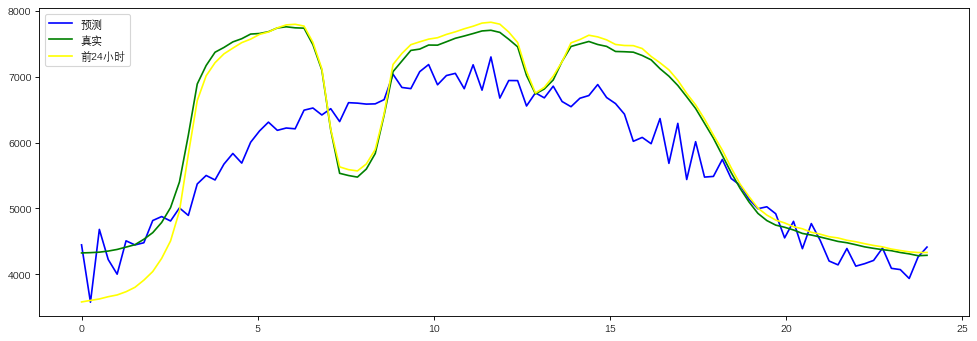

In [112]:
picture(test_seq, 500)

预测训练集里的某一样本

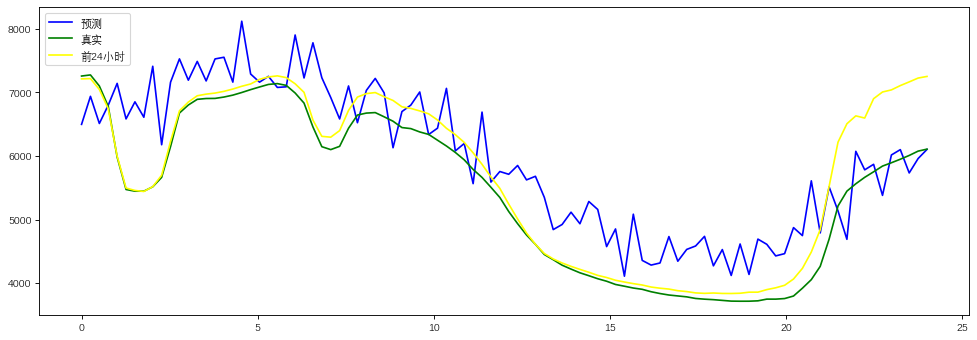

In [113]:
picture(train_seq, 66000)

加载训练好的模型参数

In [114]:
fcnn.load_state_dict(torch.load('./fcnn_5'))

<All keys matched successfully>

采用所有样本APE的平均值(mean absolute percentage error)MAPE对模型的预测准确度进行评价

APE（绝对百分比误差）：|y预测 - y真实| ÷ y真实 × 100%

In [115]:
def APE_list(test_seq):  # 预测的每个24小时的平均APE组成的列表
    list1 = []
    for i in test_seq:
        pred = fcnn(i[0])
        true_label = i[1] * (v_max - v_min) + v_min
        true_label = true_label.numpy()
        true_pred = pred * (v_max - v_min) + v_min
        true_pred = true_pred.detach().numpy()
        num = sum(abs(true_pred - true_label) / true_label) / 96
        list1.append(num)

    return list1
#max(list1), min(list1)，list1.index()

在测试数据上的MAPE

In [116]:
list1 = APE_list(test_seq)
str(sum(list1) / len(list1) * 100) + '%'

'10.530419045421855%'

In [117]:
# 保存列表
np.save('fcnn_mape', list1)

In [118]:
# 6.603606413932181%    学习率0.01
# 5.305290765717045%
# 5.3464262697033975%
# 5.14127627500452%
# 5.7158051922799915%
# 6.787916712337207%
# 6.644239348950235%
# 5.69550430048835%
# 8.271368299091874%
# 6.929466516301976%
# 5.033682719629707%   学习率0.001
# 5.111268064916269%
# 4.66893587943667%
# 5.607308426536673%
# 4.736420186128316%
# 3.671130233735497%
# 4.529471358337761%
# 4.194013957217647%
# 3.4696171180810023%
# 4.354834724221718%
# 4.402668573521657%
# 3.963668633496546%
# 3.7688639320679154%
# 4.6363068274787835%
# 3.577304760008287%
# 3.6069999537668047%
# 3.4939624582452438%
# 3.510677293122402%
# 3.5191873838763934%
# 3.371155724122247%   学习率0.0001    
# 3.2396765017178573%   
# 3.1312434051535534%   
# 3.218598760194548%
# 3.1202429503717695%
# 3.1370015644698372%
# 2.9958810460580594%   
# 2.9824408010238823%
# 3.1413491746402094%
# 3.1052736001067767%
# 3.016649604364203%
# 3.158469020480509%
# 3.189437748473799%
# 3.033976786304351%
# 2.971539336320524%
# 2.9965918989233247%  学习率0.00001
# 2.9667725922817083%
# 2.972823514175659%
# 2.9885393344417883%
# 2.971978000134556%
# 2.963206226104105%  fcnn_5
# 2.9794356459394766%

In [119]:
torch.save(fcnn.state_dict(), 'fcnn_5')

测试数据的APE分布的箱线图

<Axes: >

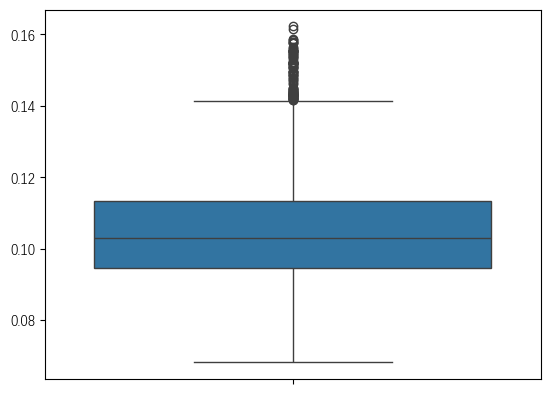

In [120]:
sns.boxplot(data=list1)

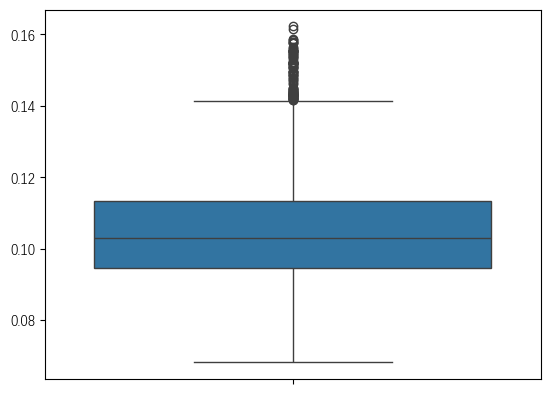

In [121]:
# sns.boxplot(data=list1)
# plt.ylim(0, 0.06)
sns.boxplot(data=list1)  # 或按上面的正确格式传参
plt.show()  # 看默认坐标轴下是否有内容

In [122]:
min(list1)

0.06812059021467576

In [123]:
max(list1)

0.1622489353370232

测试数据的APE分布的折线图

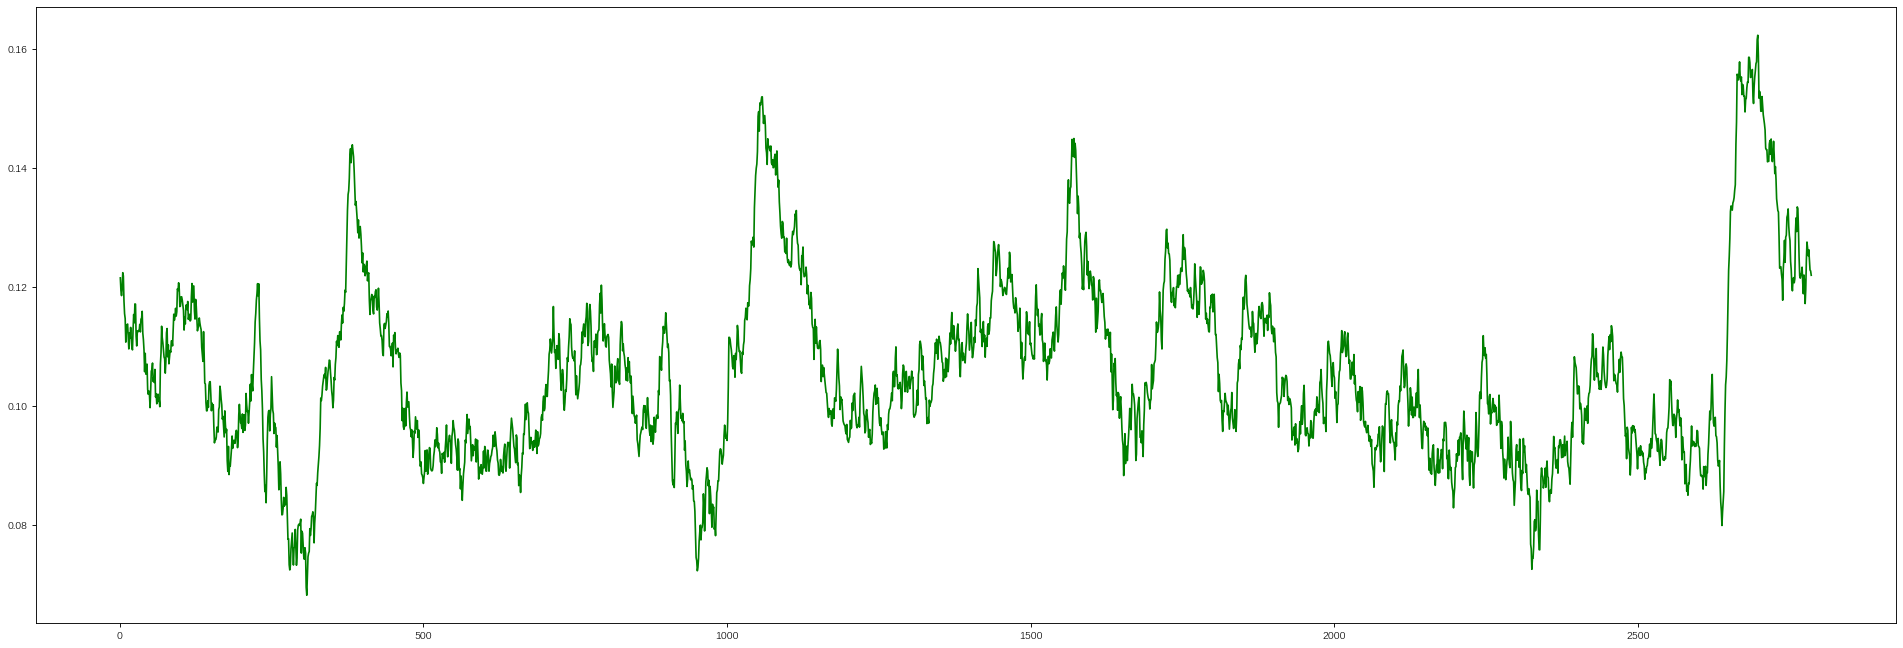

In [124]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 2785, len(list1), endpoint=True)
plt.plot(X, list1, color='green')
plt.show()

2023年12月30日的预测误差较大，观察12月30日的数据发现，这天为周五，气象数据未发现异常，且不是节假日，12月31日才是元旦假期，但负荷相较前一天出现了明显的下降，推测这是
导致误差较大的原因。

除去误差较大的预测结果后

In [125]:
list2 = list1[:2600]

In [126]:
str(sum(list2) / len(list2) * 100) + '%'

'10.378969791333367%'

<Axes: >

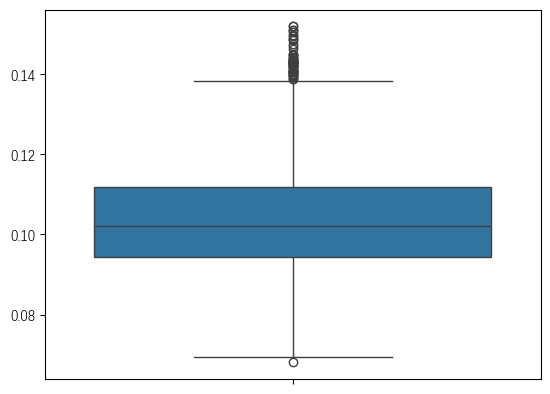

In [127]:
sns.boxplot(data=list2)

(0.0, 0.06)

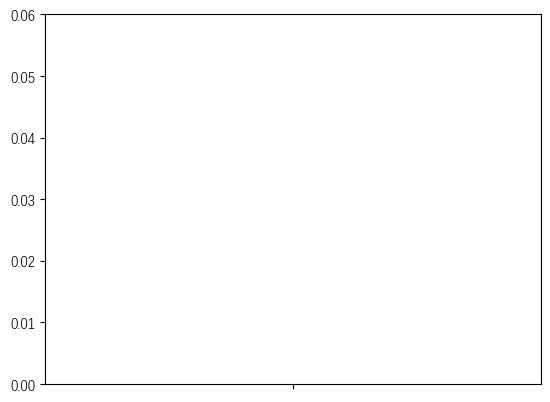

In [128]:
sns.boxplot(data=list2)
plt.ylim(0, 0.06)


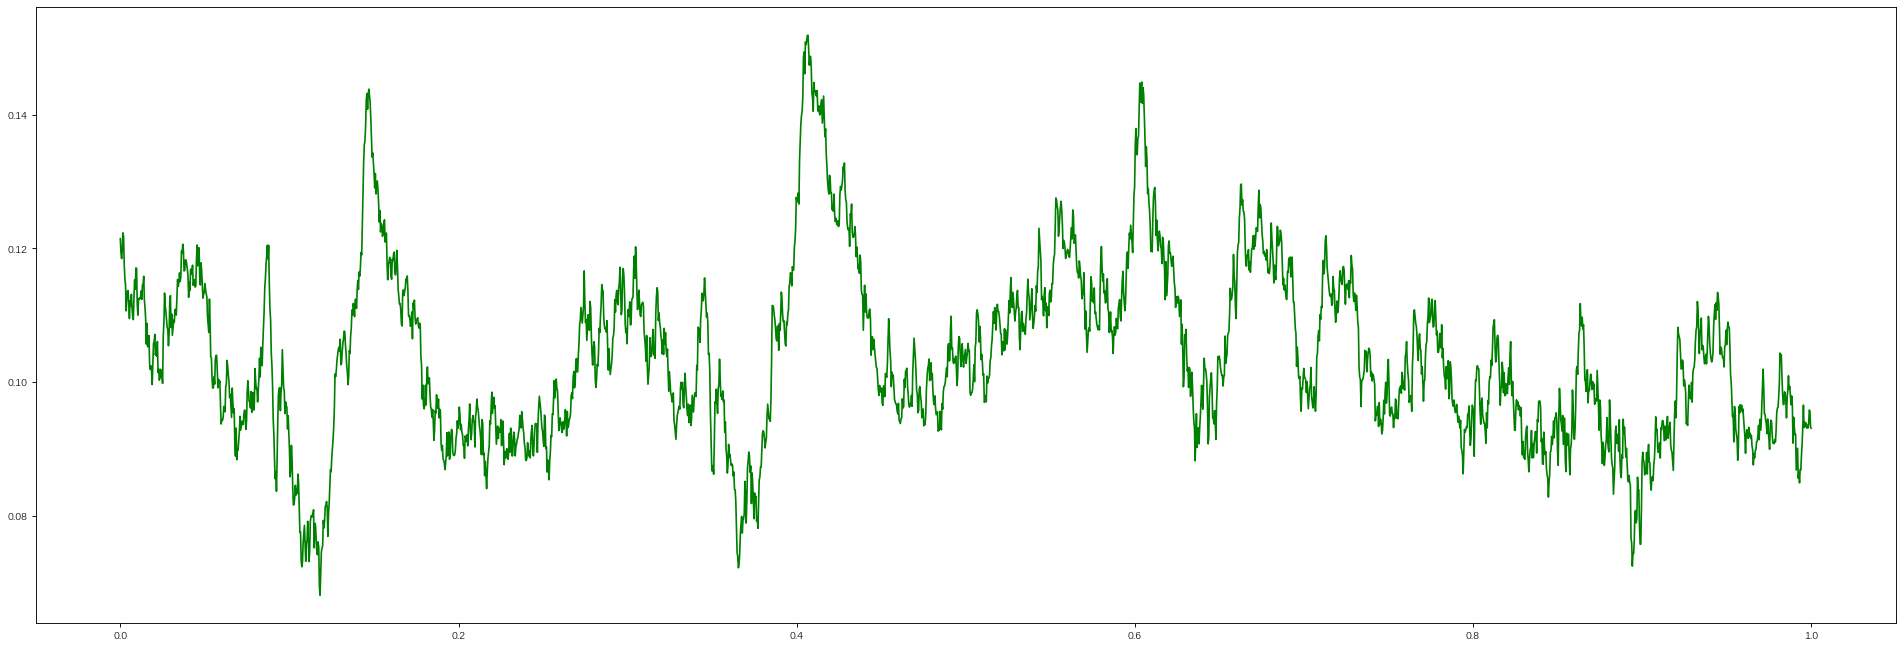

In [129]:

plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(0, 1, len(list2), endpoint=True)
plt.plot(X, list2, color='green')
plt.show()

训练过程中在训练集上损失(MSE)的折线图（以小批量为单位）

In [130]:
max(loss_list), min(loss_list), loss_list[0]

(tensor(0.3420), tensor(0.0091), tensor(0.3420))

In [131]:
len(loss_list)/521

1.0

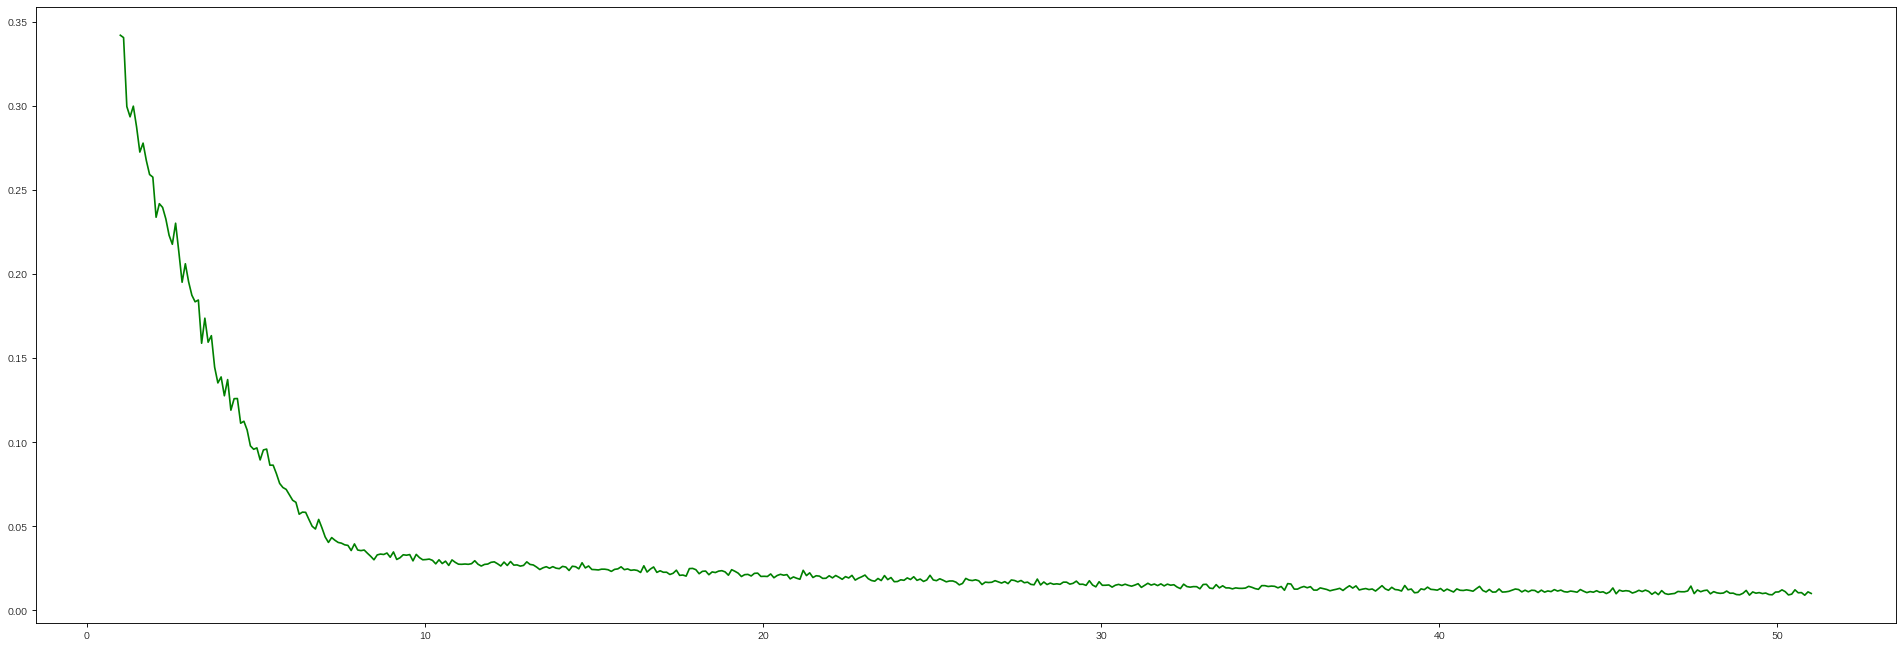

In [132]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 51, len(loss_list), endpoint=True)
plt.plot(X, loss_list, color='green')
plt.show()

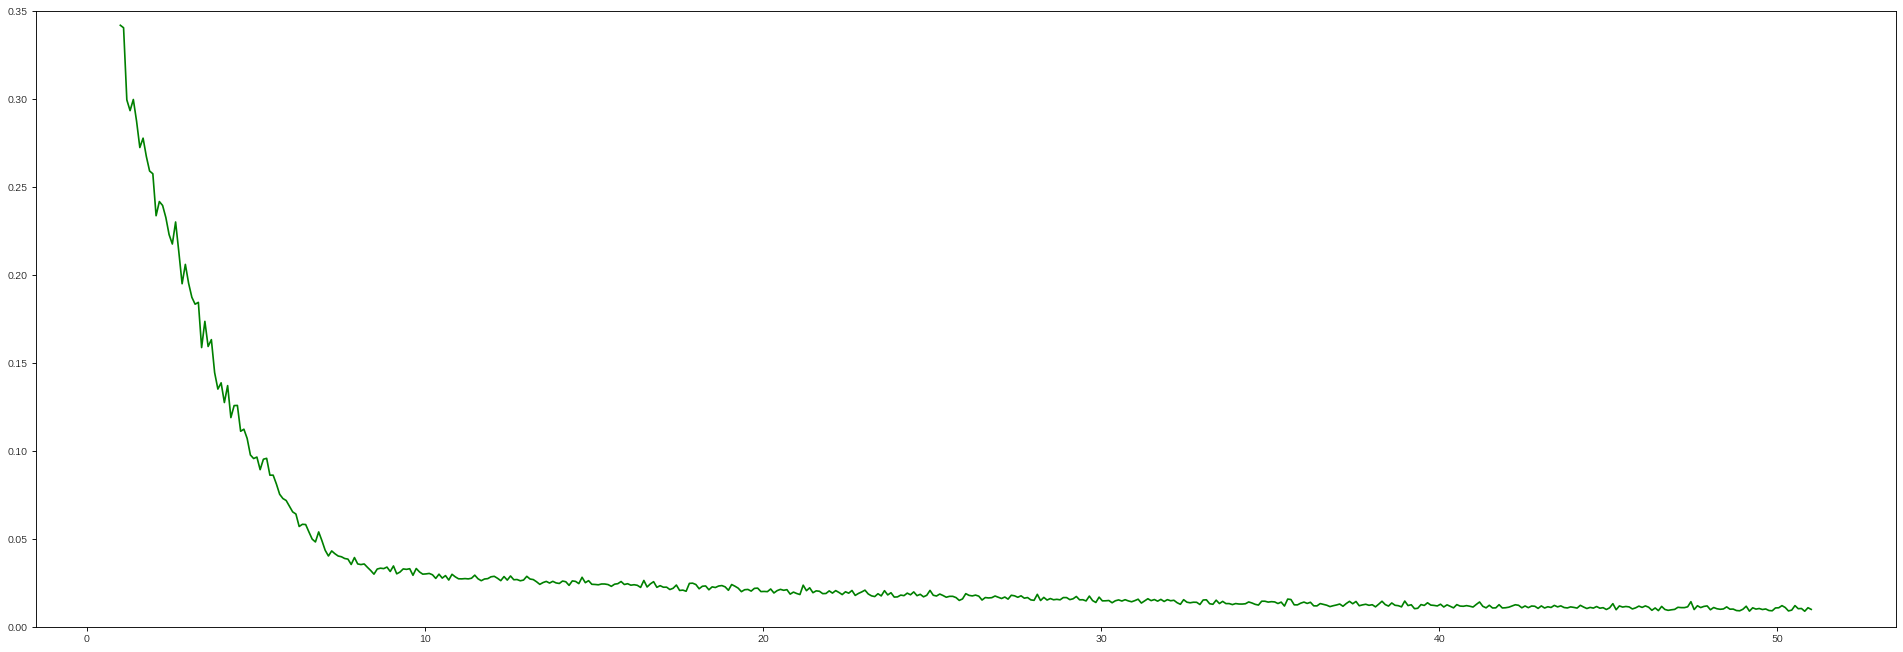

In [133]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 51, len(loss_list), endpoint=True)
plt.plot(X, loss_list, color='green')
plt.ylim(0, 0.3500)
plt.show()

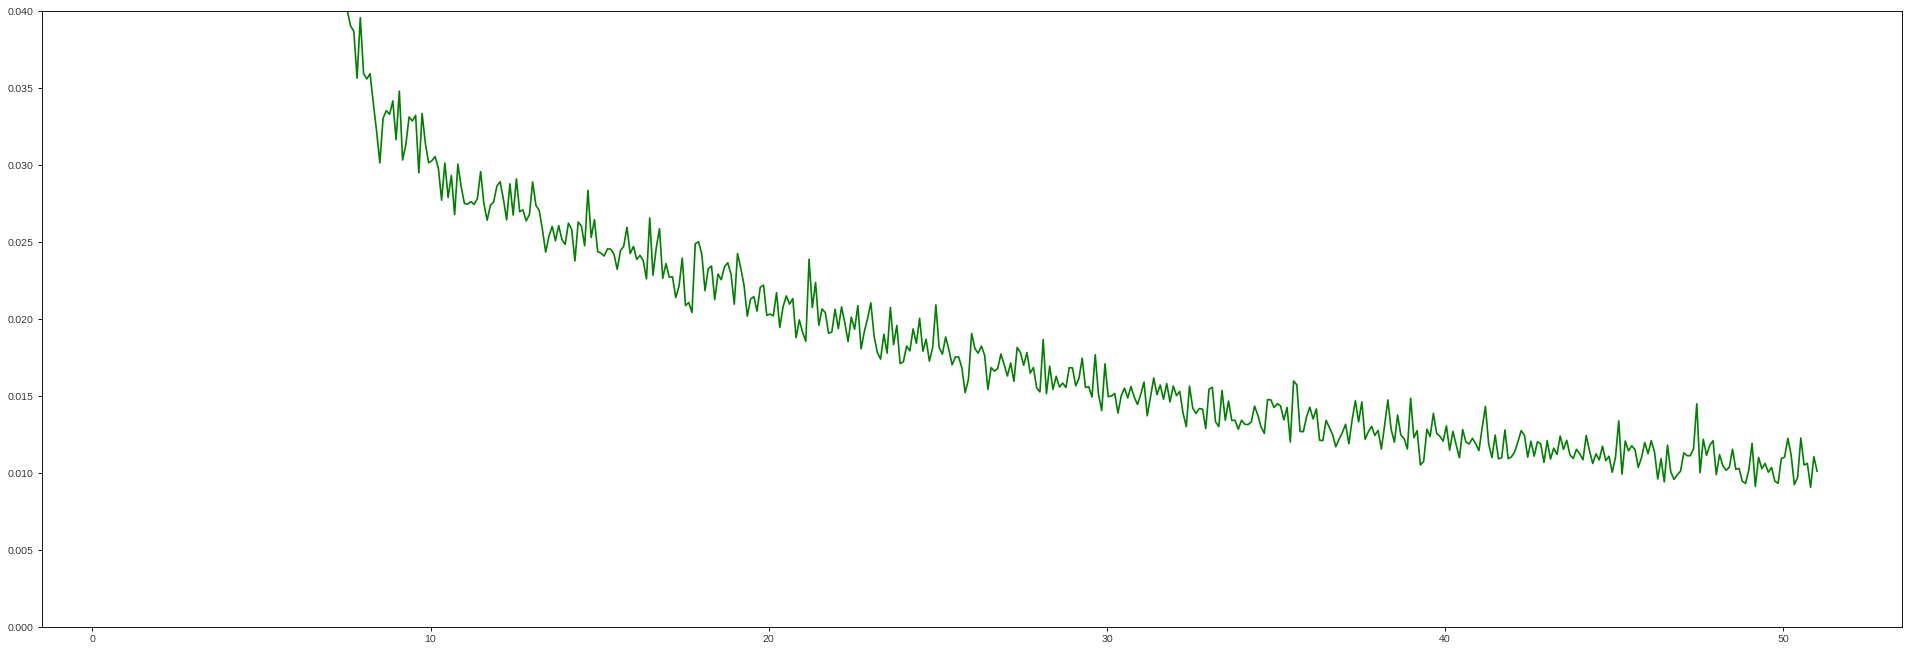

In [134]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 51, len(loss_list), endpoint=True)
plt.plot(X, loss_list, color='green')
plt.ylim(0, 0.0400)
plt.show()

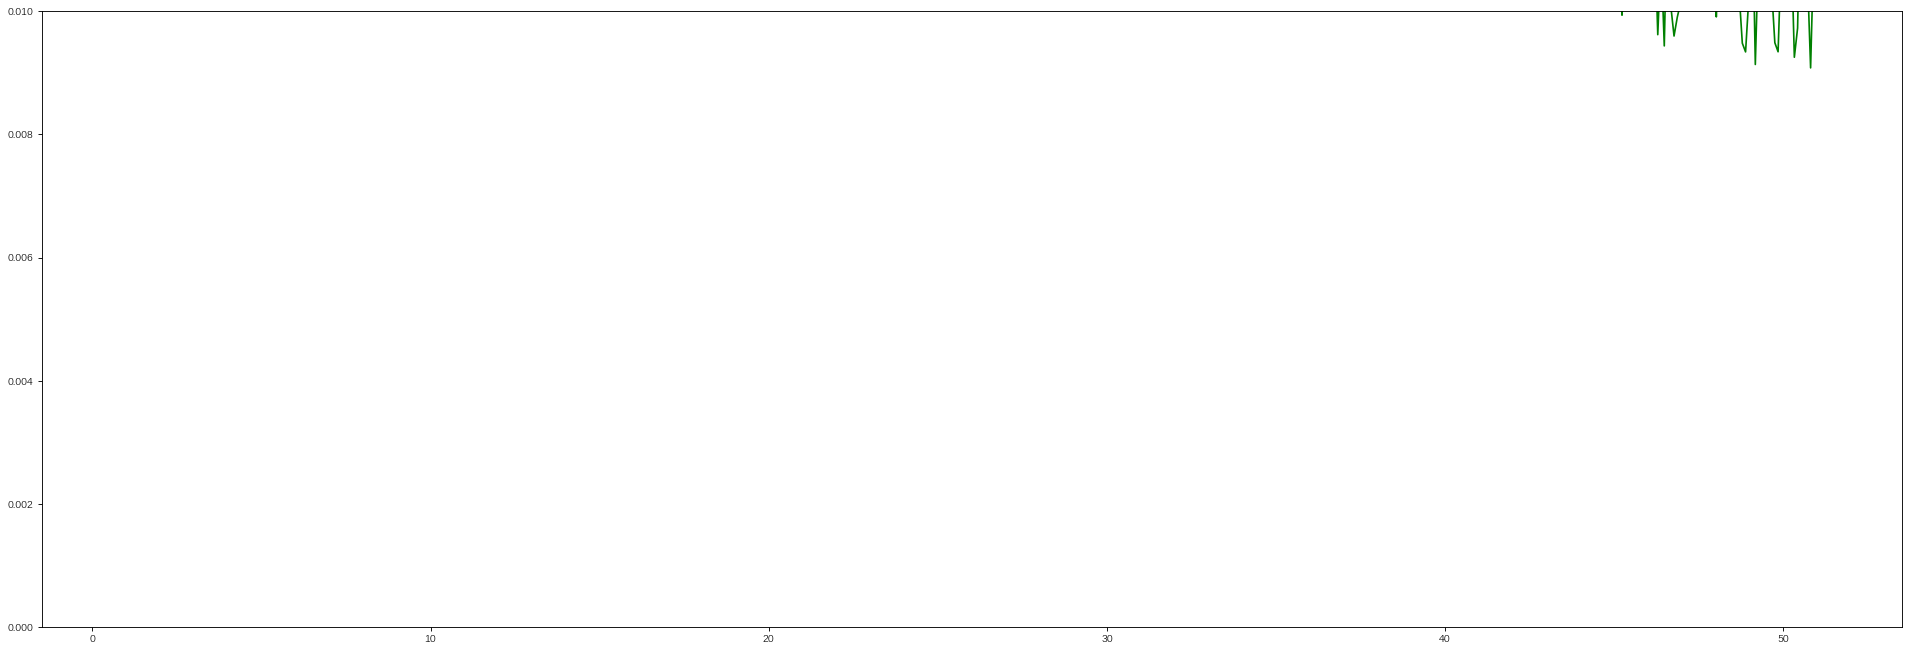

In [135]:
plt.figure(figsize=(30, 10), dpi=80)

X = np.linspace(1, 51, len(loss_list), endpoint=True)
plt.plot(X, loss_list, color='green')
plt.ylim(0, 0.0100)
plt.show()

 考虑之后用前一个星期的数据，因为负荷在一天内和一周内变化情况有较明显的规律

 考虑将要预测的第一个时刻的特征和预测时刻前24小时的那个时刻的负荷组成一个序列，预测的第二个时刻的特征和预测时刻前24小时的那个时刻的负荷组成
 一个序列......，最终一个样本有96个序列，分别对应要预测的96个时刻。就像实训2-9那样。
 考虑新增一个特征：是否为休息日（或工作日），并将节假日的调休去掉。